In [1]:
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors
    
sc = SparkContext()
sqlContext = SQLContext(sc)
spark = SparkSession(sc)

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

sns.set()
style.use('ggplot')

In [2]:
#load data
account = sqlContext.read.load(r'C:\Users\ASUS\Downloads\berka\account.csv', 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')

df_account = account.toPandas()

client = sqlContext.read.load(r'C:\Users\ASUS\Downloads\berka\client2.csv', 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')

df_client = client.toPandas()

disp = sqlContext.read.load(r'C:\Users\ASUS\Downloads\berka\disp.csv', 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')

df_disp = disp.toPandas()

card = sqlContext.read.load(r'C:\Users\ASUS\Downloads\berka\card.csv', 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')

df_card = card.toPandas()

district = sqlContext.read.load(r'C:\Users\ASUS\Downloads\berka\district.csv', 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')

df_district = district.toPandas()

loan = sqlContext.read.load(r'C:\Users\ASUS\Downloads\berka\loan.csv', 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')

df_loan = loan.toPandas()

trans = sqlContext.read.load(r'C:\Users\ASUS\Downloads\berka\trans.csv', 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')

df_trans = trans.toPandas()

In [3]:
#Joining  all the datasets
df_joined = pd.merge(df_account, df_trans, on="account_id")
df_joined = pd.merge(df_joined, df_disp, on="account_id")
df_joined = pd.merge(df_joined, df_client, on=["client_id", "district_id"])
df_joined = pd.merge(df_joined, df_district, on="district_id")

df_joined.dtypes

df_joined = df_joined.drop_duplicates()


df_joined = df_joined.drop(['district_id', 'operation', 'account',  'bank', 
                            'k_symbol', 'balance', 'A4', 'A5', 'A6', 'A7', 
                            'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 
                            'A15', 'A16'], axis=1)

df_joined.dtypes


account_id         int32
frequency         object
date_account      object
trans_id           int32
date_trans        object
type              object
amount           float64
disp_id            int32
client_id          int32
type_disp         object
birth_date        object
age                int32
gender            object
district_name     object
region            object
dtype: object

In [4]:
#RFM for customer loyalty segmentation
temp = df_joined.groupby(by=['client_id', 'trans_id'], as_index=False)['amount'].sum()
total_amount = temp.rename(columns = {'amount':'total_amount'})


df_joined['date_trans'] = pd.to_datetime(df_joined['date_trans'])
df_joined['date_account'] = pd.to_datetime(df_joined['date_account'])

df_joined['date_trans_int'] = df_joined['date_trans'].astype('int64')
temp = df_joined.groupby(by=['client_id', 'trans_id'], as_index=False)['date_trans_int'].mean()

df_joined.drop('date_trans_int', axis = 1, inplace = True)
total_amount.loc[:, 'date_trans'] = pd.to_datetime(temp['date_trans_int'])


total_amount = total_amount[total_amount['total_amount'] > 0]
total_amount.sort_values('client_id')[:6]

lastDate = df_joined['date_trans'].max()

total_amount['date_trans'] = pd.to_datetime(total_amount['date_trans'])

rfmTable = total_amount.groupby('client_id').agg({'date_trans': lambda x: (lastDate - x.max()).days, 
                                           'trans_id': lambda x: len(x), 
                                           'total_amount': lambda x: x.sum()})

rfmTable['date_trans'] = rfmTable['date_trans'].astype(int)


rfmTable.rename(columns={'date_trans': 'Recency', 
                         'trans_id': 'Frequency', 
                         'total_amount': 'Monetary'}, inplace=True)

In [5]:

f_score = []
m_score = []
r_score = []

columns = ['Frequency', 'Monetary']
scores_str = ['f_score', 'm_score']

scores = [f_score, m_score]


for n in range(len(columns)):
    # Order by column
    rfmTable = rfmTable.sort_values(columns[n], ascending=False)
    
    # Create new index
    refs = np.arange(1,4876)
    rfmTable['refs'] = refs
    
    # Add score
    for i, row in rfmTable.iterrows():
        if row['refs'] <= 975:
            scores[n].append(5)
        elif row['refs'] > 975 and row['refs'] <= 975*2:
            scores[n].append(4)
        elif row['refs'] > 975*2 and row['refs'] <= 975*3:
            scores[n].append(3)
        elif row['refs'] > 975*3 and row['refs'] <= 975*4:
            scores[n].append(2)
        else: 
            scores[n].append(1)

    # Create f_score column
    rfmTable[scores_str[n]] = scores[n]
    
# For recency, we do the opposite: most recents are better, so we order as ascending
rfmTable = rfmTable.sort_values('Recency', ascending=True)
  
# Recreate index
refs = np.arange(1,4876)
rfmTable['refs'] = refs

# Add score
for i, row in rfmTable.iterrows():
    if row['refs'] <= 975:
        r_score.append(5)
    elif row['refs'] > 975 and row['refs'] <= 975*2:
        r_score.append(4)
    elif row['refs'] > 975*2 and row['refs'] <= 975*3:
        r_score.append(3)
    elif row['refs'] > 975*3 and row['refs'] <= 975*4:
        r_score.append(2)
    else: 
        r_score.append(1)

In [6]:
# Create f_score column
rfmTable['r_score'] = r_score
rfmTable['rfm_score'] = rfmTable[['r_score','f_score','m_score']].sum(axis=1)
rfmTable['rfm_score'].min() 
rfmTable['rfm_score'].max()
rfmTableScores = rfmTable.drop(['Frequency', 'Monetary', 'Recency', 'refs', 'rfm_score'], axis=1)
rfmTableScores

,f_score,m_score,r_score
client_id,,,
255,5,5,5
2717,3,2,5
2718,3,2,5
4704,1,2,5
3323,3,2,5
4491,2,2,5
4469,3,2,5
1334,2,2,5
49,1,2,5


In [7]:
from sklearn.preprocessing import StandardScaler
import numpy as np
#Data normalization
data_log = np.log(rfmTableScores)
scaler = StandardScaler()
scaler.fit(data_log)
data_normalized  = scaler.transform(data_log)
data_normalized = pd.DataFrame(data=data_normalized, index=rfmTableScores.index, columns=rfmTableScores.columns)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
#Reshape the dataframe to 2D dimensions
pca = PCA(n_components=2)
reduced = pca.fit_transform(data_normalized) 
#Rename columns
tmp = pd.DataFrame(reduced, columns=['x', 'y']) 
tmp

,x,y
0,-0.932014,-1.678337
1,0.679896,-1.054746
2,0.679896,-1.054746
3,1.821526,-0.014308
4,0.679896,-1.054746
5,1.101238,-0.670751
6,0.679896,-1.054746
7,1.101238,-0.670751
8,1.821526,-0.014308
9,1.101238,-0.670751


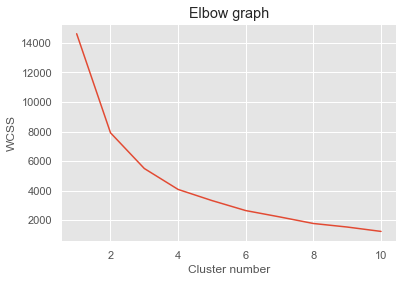

In [8]:
from sklearn.cluster import KMeans

#Find wcss for every K between 1 and 11
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(data_normalized)
    wcss.append(kmeans.inertia_)
#Plot the elbow graph
plt.plot(range(1,11), wcss)
plt.title('Elbow graph')
plt.xlabel('Cluster number')
plt.ylabel('WCSS')
plt.show()

In [9]:
#Apply K-means for the best k=3
km = KMeans(n_clusters=3)
clusters = km.fit(data_normalized)
cluster_labels = clusters.labels_
clusters = km.fit_predict(data_normalized)
#Add the cluster number for every row
rfmTable['cluster'] = clusters
c1 = rfmTable[rfmTable.cluster == 0]
c2 = rfmTable[rfmTable.cluster == 1]
c3 = rfmTable[rfmTable.cluster == 2]

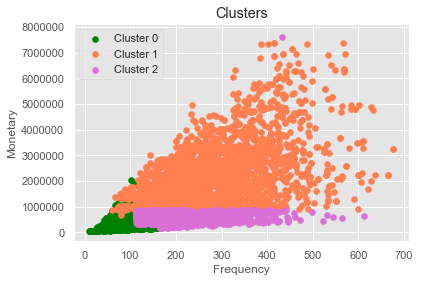

In [10]:
#Plot the clusters by Frequency and Monetary 
plt.scatter(c1.Frequency, c1.Monetary, c = 'green', label = 'Cluster 0')
plt.scatter(c2.Frequency, c2.Monetary, c = 'coral', label = 'Cluster 1')
plt.scatter(c3.Frequency, c3.Monetary, c = 'orchid', label = 'Cluster 2')

plt.title('Clusters')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.legend()
plt.show()

In [11]:
#Add the cluster number for every row
rfmTable['cluster'] = clusters
c1 = rfmTable[rfmTable.cluster == 0]
c2 = rfmTable[rfmTable.cluster == 1]
c3 = rfmTable[rfmTable.cluster == 2]

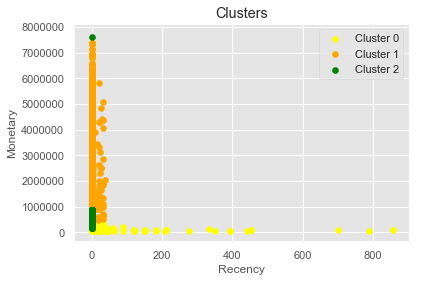

In [12]:
plt.scatter(c1.Recency, c1.Monetary, c = 'yellow', label = 'Cluster 0')
plt.scatter(c2.Recency, c2.Monetary, c = 'orange', label = 'Cluster 1')
plt.scatter(c3.Recency, c3.Monetary, c = 'green', label = 'Cluster 2')

plt.title('Clusters')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.legend()

In [13]:
data_rfm = rfmTableScores.assign(Cluster=cluster_labels)
grouped = data_rfm.groupby(['Cluster'])
grouped.agg({
    'r_score': 'mean',
    'f_score': 'mean',
    'm_score': 'mean'
  }).round(1)

,r_score,f_score,m_score
Cluster,,,
0,1.9,3.7,4.2
1,3.6,1.3,1.4
2,4.4,3.3,2.2


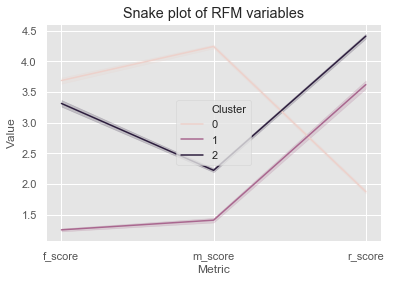

In [14]:
data_melt = pd.melt(
                    data_rfm.reset_index(),               
                    id_vars=['client_id', 'Cluster'],
                    value_vars=['r_score', 'f_score', 'm_score'], 
                    var_name='Metric', value_name='Value'
                    )
# Snake Plot
plt.title('Snake plot of RFM variables')
plt.xlabel('Metric')
plt.ylabel('Value')
sns.lineplot(data=data_melt, x='Metric', y='Value', hue='Cluster')
plt.show()

Cluster 0: Best

Cluster 2: Risky

Cluster 1: About to sleep

In [15]:
tmp['cluster'] = clusters
tmp

,x,y,cluster
0,-0.932014,-1.678337,2
1,0.679896,-1.054746,2
2,0.679896,-1.054746,2
3,1.821526,-0.014308,0
4,0.679896,-1.054746,2
5,1.101238,-0.670751,2
6,0.679896,-1.054746,2
7,1.101238,-0.670751,2
8,1.821526,-0.014308,0
9,1.101238,-0.670751,2


In [16]:
data_normalized

,f_score,m_score,r_score
client_id,,,
255,1.146939,1.146939,1.146939
2717,0.248258,-0.465066,1.146939
2718,0.248258,-0.465066,1.146939
4704,-1.684500,-0.465066,1.146939
3323,0.248258,-0.465066,1.146939
4491,-0.465066,-0.465066,1.146939
4469,0.248258,-0.465066,1.146939
1334,-0.465066,-0.465066,1.146939
49,-1.684500,-0.465066,1.146939


In [17]:
aux = data_normalized.copy()
aux.reset_index(level=0, inplace=True)
column_client_id = aux['client_id']

In [18]:
aux

,client_id,f_score,m_score,r_score
0,255,1.146939,1.146939,1.146939
1,2717,0.248258,-0.465066,1.146939
2,2718,0.248258,-0.465066,1.146939
3,4704,-1.684500,-0.465066,1.146939
4,3323,0.248258,-0.465066,1.146939
5,4491,-0.465066,-0.465066,1.146939
6,4469,0.248258,-0.465066,1.146939
7,1334,-0.465066,-0.465066,1.146939
8,49,-1.684500,-0.465066,1.146939
9,379,-0.465066,-0.465066,1.146939


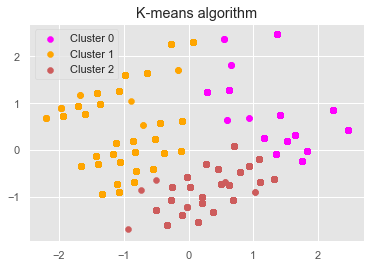

In [19]:
tmp['cluster'] = clusters

c1 = tmp[tmp.cluster == 0]
c2 = tmp[tmp.cluster == 1]
c3 = tmp[tmp.cluster == 2]

plt.scatter(c1.x, c1.y, c = 'magenta', label = 'Cluster 0')
plt.scatter(c2.x, c2.y, c = 'orange', label = 'Cluster 1')
plt.scatter(c3.x, c3.y, c = 'indianred', label = 'Cluster 2')


plt.title('K-means algorithm')
plt.legend()

In [20]:
df_loyalty_3 = tmp
df_loyalty_3['client_id'] = column_client_id

In [21]:
df_loyalty_3 = df_loyalty_3.replace(2, 'Risky')
df_loyalty_3 = df_loyalty_3.replace(0, 'Best')
df_loyalty_3 = df_loyalty_3.replace(1, 'About to sleep')

In [22]:
df_loyalty_3

,x,y,cluster,client_id
0,-0.932014,-1.678337,Risky,255
1,0.679896,-1.054746,Risky,2717
2,0.679896,-1.054746,Risky,2718
3,1.821526,-0.014308,Best,4704
4,0.679896,-1.054746,Risky,3323
5,1.101238,-0.670751,Risky,4491
6,0.679896,-1.054746,Risky,4469
7,1.101238,-0.670751,Risky,1334
8,1.821526,-0.014308,Best,49
9,1.101238,-0.670751,Risky,379


In [23]:
df_loyalty_3.to_csv (r'C:\Users\ASUS\Downloads\berka\df_loyalty_3.csv', index = None, header=True) 

# Accuracy of k-means

In [24]:
aux = df_loyalty_3.copy()
aux

,x,y,cluster,client_id
0,-0.932014,-1.678337,Risky,255
1,0.679896,-1.054746,Risky,2717
2,0.679896,-1.054746,Risky,2718
3,1.821526,-0.014308,Best,4704
4,0.679896,-1.054746,Risky,3323
5,1.101238,-0.670751,Risky,4491
6,0.679896,-1.054746,Risky,4469
7,1.101238,-0.670751,Risky,1334
8,1.821526,-0.014308,Best,49
9,1.101238,-0.670751,Risky,379


In [25]:
aux = aux.replace('Risky', 2)
aux = aux.replace('Best', 1)
aux = aux.replace('About to sleep', 0)

In [26]:
from sklearn import metrics
from sklearn.model_selection import train_test_split

y = aux['cluster'].values

X = aux.drop('cluster', axis=1)

In [27]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.30, random_state=50)

In [29]:
km.fit(X_train)

labels = km.predict(X_test)

score = metrics.accuracy_score(y_test,labels)

print('Accuracy:{0:f}'.format(score))

Accuracy:0.386876


In [30]:
tmp = tmp.drop('cluster', axis=1)
tmp

,x,y,client_id
0,-0.932014,-1.678337,255
1,0.679896,-1.054746,2717
2,0.679896,-1.054746,2718
3,1.821526,-0.014308,4704
4,0.679896,-1.054746,3323
5,1.101238,-0.670751,4491
6,0.679896,-1.054746,4469
7,1.101238,-0.670751,1334
8,1.821526,-0.014308,49
9,1.101238,-0.670751,379


# Gaussian Mixture Model

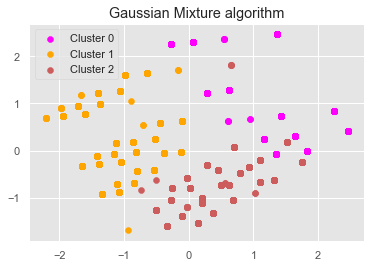

In [31]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3).fit(data_normalized)
labels = gmm.predict(data_normalized)


tmp['cluster'] = labels

c1 = tmp[tmp.cluster == 0]
c2 = tmp[tmp.cluster == 1]
c3 = tmp[tmp.cluster == 2]


plt.scatter(c1.x, c1.y, c = 'magenta', label = 'Cluster 0')
plt.scatter(c2.x, c2.y, c = 'orange', label = 'Cluster 1')
plt.scatter(c3.x, c3.y, c = 'indianred', label = 'Cluster 2')

plt.title('Gaussian Mixture algorithm')
plt.legend()

# Accuracy of GMM

In [32]:
y = tmp['cluster'].values

In [33]:
tmp = tmp.drop('cluster', axis=1)
tmp

,x,y,client_id
0,-0.932014,-1.678337,255
1,0.679896,-1.054746,2717
2,0.679896,-1.054746,2718
3,1.821526,-0.014308,4704
4,0.679896,-1.054746,3323
5,1.101238,-0.670751,4491
6,0.679896,-1.054746,4469
7,1.101238,-0.670751,1334
8,1.821526,-0.014308,49
9,1.101238,-0.670751,379


In [34]:
X_train, X_test, y_train, y_test =  train_test_split(tmp, y, test_size=0.30, random_state=50)

In [35]:
gmm.fit(X_train)

labels = gmm.predict(X_test)

score = metrics.accuracy_score(y_test,labels)

print('Accuracy:{0:f}'.format(score))

Accuracy:0.326726


# Expectation Maximization Algorithm

In [36]:
#Applying EM algorithm
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels


centers, labels = find_clusters(reduced, 3)

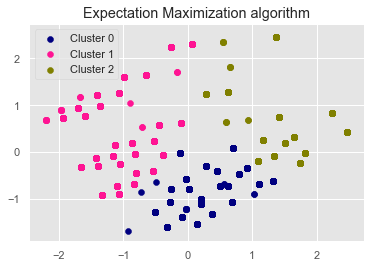

In [37]:
tmp['cluster'] = labels

c1 = tmp[tmp.cluster == 0]
c2 = tmp[tmp.cluster == 1]
c3 = tmp[tmp.cluster == 2]


plt.scatter(c1.x, c1.y, c = 'navy', label = 'Cluster 0')
plt.scatter(c2.x, c2.y, c = 'deeppink', label = 'Cluster 1')
plt.scatter(c3.x, c3.y, c = 'olive', label = 'Cluster 2')


plt.title('Expectation Maximization algorithm')
plt.legend()

# Mean Shift Algorithm

In [38]:
#Mean Shift 
from sklearn.cluster import MeanShift, estimate_bandwidth

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(data_normalized, quantile=0.25, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(data_normalized)

MeanShift(bandwidth=1.4734518496881683, bin_seeding=True, cluster_all=True,
     min_bin_freq=1, n_jobs=None, seeds=None)

In [39]:
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
print("Number of estimated clusters : %d" % n_clusters_)

Number of estimated clusters : 3


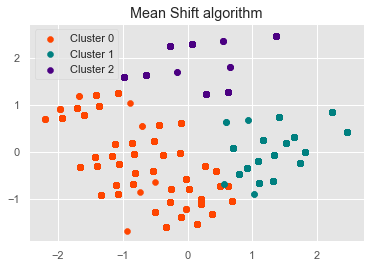

In [40]:
tmp['cluster'] = labels


c1 = tmp[tmp.cluster == 0]
c2 = tmp[tmp.cluster == 1]
c3 = tmp[tmp.cluster == 2]


plt.scatter(c1.x, c1.y, c = 'orangered', label = 'Cluster 0')
plt.scatter(c2.x, c2.y, c = 'teal', label = 'Cluster 1')
plt.scatter(c3.x, c3.y, c = 'indigo', label = 'Cluster 2')

plt.title('Mean Shift algorithm')
plt.legend()

# Accuracy of Mean Shift

In [41]:
y = tmp['cluster'].values

In [42]:
tmp = tmp.drop('cluster', axis=1)
tmp

,x,y,client_id
0,-0.932014,-1.678337,255
1,0.679896,-1.054746,2717
2,0.679896,-1.054746,2718
3,1.821526,-0.014308,4704
4,0.679896,-1.054746,3323
5,1.101238,-0.670751,4491
6,0.679896,-1.054746,4469
7,1.101238,-0.670751,1334
8,1.821526,-0.014308,49
9,1.101238,-0.670751,379


In [43]:
X_train, X_test, y_train, y_test =  train_test_split(tmp, y, test_size=0.30, random_state=50)

In [44]:
ms.fit(X_train)

labels = ms.predict(X_test)

score = metrics.accuracy_score(y_test,labels)

print('Accuracy:{0:f}'.format(score))

Accuracy:0.000684


# DBSCAN

In [58]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.5, min_samples=300).fit(data_normalized)

In [59]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
lab = db.labels_
n_clusters_ = len(set(lab)) - (1 if -1 in lab else 0)

print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 2


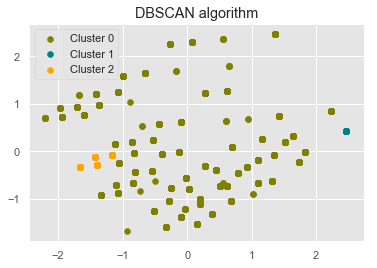

In [60]:
tmp['cluster'] = lab

c0 = tmp[tmp.cluster == -1]
c1 = tmp[tmp.cluster == 0]
c2 = tmp[tmp.cluster == 1]


plt.scatter(c0.x, c0.y, c = 'olive', label = 'Cluster 0')
plt.scatter(c1.x, c1.y, c = 'teal', label = 'Cluster 1')
plt.scatter(c2.x, c2.y, c = 'orange', label = 'Cluster 2')


plt.title('DBSCAN algorithm')
plt.legend()

# Accuracy results

Expectation Maximization algorithm is not predefined so it has not a predict method and hence we could not apply the accuracy_score method to calculate its accuracy but we coul confirm its rapidity and the interesting partioning it gave us.

DBSCAN also has not a predict method that's why we can not calculate its accuracy nevertheless it is important while dealing with real attributes and considering densities variation of labels though its latency and we can ot determine the optimal eps value for clustering.

    Clustering algorithm     |    Accuracy score
    
    Kmeans                   |    0.38
    
    Gaussian Mixture         |    0.32
    
    Mean Shift               |    0.006

As a result we will keep on using K-means clustering algorithm because it gave us the best performance results in terms of execution time and accuracy score which is 0.38 without any need to retest every used clustering algorithm for each clustering.

In [64]:
#Apply K-means for the best k=4
km = KMeans(n_clusters=4)
clusters = km.fit(data_normalized)
cluster_labels = clusters.labels_
clusters = km.fit_predict(data_normalized)

In [65]:
data_rfm = rfmTableScores.assign(Cluster=cluster_labels)

grouped = data_rfm.groupby(['Cluster'])
grouped.agg({
    'r_score': 'mean',
    'f_score': 'mean',
    'm_score': 'mean'
  }).round(1)

,r_score,f_score,m_score
Cluster,,,
0,2.4,4.2,4.6
1,3.6,1.2,1.4
2,4.4,3.3,2.2
3,1.1,3.0,3.7


In [66]:
data_melt = pd.melt(
                    data_rfm.reset_index(),               
                    id_vars=['client_id', 'Cluster'],
                    value_vars=['r_score', 'f_score', 'm_score'], 
                    var_name='Metric', value_name='Value'
                    )

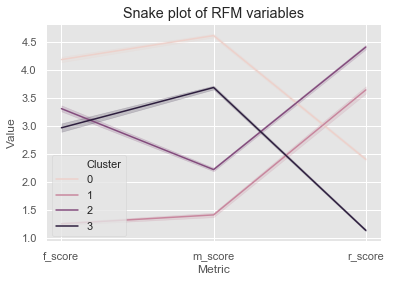

In [67]:
# Snake Plot
plt.title('Snake plot of RFM variables')
plt.xlabel('Metric')
plt.ylabel('Value')
sns.lineplot(data=data_melt, x='Metric', y='Value', hue='Cluster')
plt.show()

Cluster 3: Best

Cluster 0: Loyal

Cluster 2: Risky

Cluster 1: About to sleep

In [68]:
tmp['cluster'] = clusters

In [69]:
c1 = tmp[tmp.cluster == 0]
c2 = tmp[tmp.cluster == 1]
c3 = tmp[tmp.cluster == 2]
c4 = tmp[tmp.cluster == 3]

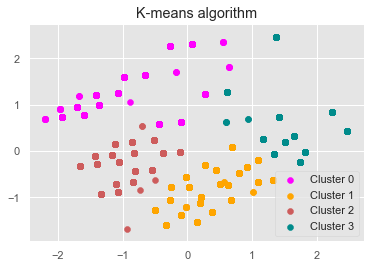

In [70]:
plt.scatter(c1.x, c1.y, c = 'magenta', label = 'Cluster 0')
plt.scatter(c2.x, c2.y, c = 'orange', label = 'Cluster 1')
plt.scatter(c3.x, c3.y, c = 'indianred', label = 'Cluster 2')
plt.scatter(c4.x, c4.y, c = 'darkcyan', label = 'Cluster 3')

plt.title('K-means algorithm')
plt.legend()

In [73]:
df_loyalty_4 = tmp
df_loyalty_4['client_id'] = column_client_id

In [74]:
df_loyalty_4 = df_loyalty_4.replace(0, 'Loyal')
df_loyalty_4 = df_loyalty_4.replace(1, 'About to sleep')
df_loyalty_4 = df_loyalty_4.replace(2, 'Risky')
df_loyalty_4 = df_loyalty_4.replace(3, 'Best')

In [75]:
df_loyalty_4.to_csv (r'C:\Users\ASUS\Downloads\berka\df_loyalty_4.csv', index = None, header=True) 

In [76]:
#Segmentation per age 
df_age = df_joined[['client_id', 'age']]


from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

df_age = df_age.drop_duplicates()

C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int32 were all converted to float64 by StandardScaler.
  """


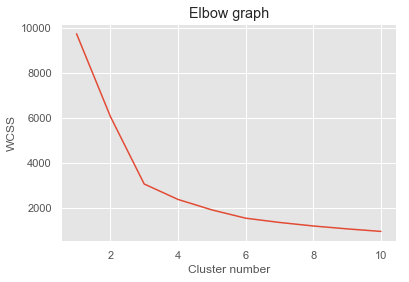

In [77]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df_age)
data_norm = scaler.transform(df_age)
data_norm = pd.DataFrame(data=data_norm, index=df_age.index, columns=df_age.columns)


pca = PCA(n_components=2)
tmp_age = pca.fit_transform(data_norm) 

# k means determine k by elbow method
#Find wcss for every K between 1 and 11
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(data_norm)
    wcss.append(kmeans.inertia_)


#Plot the elbow graph
plt.plot(range(1,11), wcss)
plt.title('Elbow graph')
plt.xlabel('Cluster number')
plt.ylabel('WCSS')
plt.show()

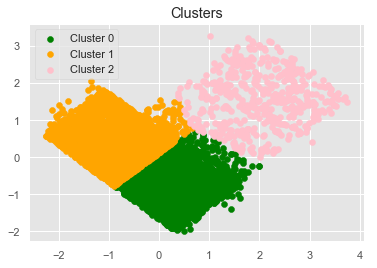

In [78]:
km = KMeans(n_clusters=3)
clusters = km.fit(data_norm)
cluster_labels = clusters.labels_
clusters = km.fit_predict(data_norm)


tmp_age_3 = pd.DataFrame(tmp_age, columns=['x', 'y']) 

tmp_age_3['cluster'] = clusters

c1 = tmp_age_3[tmp_age_3.cluster == 0]
c2 = tmp_age_3[tmp_age_3.cluster == 1]
c3 = tmp_age_3[tmp_age_3.cluster == 2]


plt.scatter(c1.x, c1.y, c = 'green', label = 'Cluster 0')
plt.scatter(c2.x, c2.y, c = 'orange', label = 'Cluster 1')
plt.scatter(c3.x, c3.y, c = 'pink', label = 'Cluster 2')

plt.title('Clusters')
plt.legend()
plt.show()


tmp_age_3['client_id'] = column_client_id

In [79]:
data = df_age

data['cluster'] = clusters

In [80]:
data[data['cluster'] == 0].describe()

,client_id,age,cluster
count,2283.000000,2283.000000,2283.0
mean,2635.317565,51.503285,0.0
std,1566.214445,8.551251,0.0
min,1.000000,31.000000,0.0
25%,1254.000000,44.000000,0.0
50%,2617.000000,51.000000,0.0
75%,3944.000000,59.000000,0.0
max,6804.000000,66.000000,0.0


In [81]:
data[data['cluster'] == 1].describe()

,client_id,age,cluster
count,2125.000000,2125.000000,2125.0
mean,2547.356706,81.557176,1.0
std,1497.619335,9.896125,0.0
min,2.000000,67.000000,1.0
25%,1298.000000,73.000000,1.0
50%,2491.000000,80.000000,1.0
75%,3737.000000,89.000000,1.0
max,7043.000000,107.000000,1.0


In [82]:
data[data['cluster'] == 2].describe()

,client_id,age,cluster
count,467.000000,467.000000,467.0
mean,10450.539615,59.770878,2.0
std,2087.216225,12.465617,0.0
min,6342.000000,33.000000,2.0
25%,8673.500000,49.500000,2.0
50%,10564.000000,60.000000,2.0
75%,12112.500000,70.000000,2.0
max,13998.000000,93.000000,2.0


In order to label the 3 clusters we have found after applying K-means and calculating the average age of customers in every cluster, we will give them the senior, junior, and old labels. 

So, we will name the cluster having the average age up to 50 as senior, the one having the average up to 60 junior, and finally the cluster old having 80 as average age. 

Cluster 0: Senior between 30 and 66 years-old.

Cluster 1: Old between 67 and 107 years-old. 

Cluster 2: Junior between 33 and 93 years-old.

In [83]:
tmp_age_3 = tmp_age_3.replace(0, 'Senior')
tmp_age_3 = tmp_age_3.replace(1, 'Old')
tmp_age_3 = tmp_age_3.replace(2, 'Junior')

In [84]:
tmp_age_3

,x,y,cluster,client_id
0,0.755940,-0.993873,Senior,255
1,-0.498497,-0.694425,Senior,2717
2,-1.416744,1.086181,Old,2718
3,0.428484,-0.258144,Senior,4704
4,-1.468113,-0.028372,Old,3323
5,0.284095,-0.647884,Senior,4491
6,0.572164,0.458019,Senior,4469
7,0.139429,-0.301849,Senior,1334
8,0.798638,-0.705825,Senior,49
9,-1.927464,0.575461,Old,379


In [85]:
tmp_age_3.to_csv (r'C:\Users\ASUS\Downloads\berka\df_age_3.csv', index = None, header=True) 

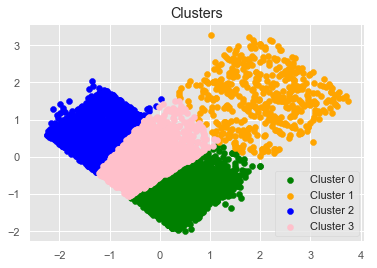

In [86]:
km = KMeans(n_clusters=4)
clusters = km.fit(data_norm)
cluster_labels = clusters.labels_
clusters = km.fit_predict(data_norm)


tmp_age_4 = pd.DataFrame(tmp_age, columns=['x', 'y']) 

tmp_age_4['cluster'] = clusters

c1 = tmp_age_4[tmp_age_4.cluster == 0]
c2 = tmp_age_4[tmp_age_4.cluster == 1]
c3 = tmp_age_4[tmp_age_4.cluster == 2]
c4 = tmp_age_4[tmp_age_4.cluster == 3]


plt.scatter(c1.x, c1.y, c = 'green', label = 'Cluster 0')
plt.scatter(c2.x, c2.y, c = 'orange', label = 'Cluster 1')
plt.scatter(c3.x, c3.y, c = 'blue', label = 'Cluster 2')
plt.scatter(c4.x, c4.y, c = 'pink', label = 'Cluster 3')

plt.title('Clusters')
plt.legend()
plt.show()


tmp_age_4['client_id'] = column_client_id

In [87]:
data['cluster'] = clusters

In [88]:
data[data['cluster'] == 0].describe()

,client_id,age,cluster
count,1646.000000,1646.000000,1646.0
mean,2561.919198,47.346294,0.0
std,1578.513210,6.070438,0.0
min,1.000000,31.000000,0.0
25%,1161.250000,42.000000,0.0
50%,2515.500000,47.000000,0.0
75%,3877.750000,52.000000,0.0
max,6804.000000,59.000000,0.0


In [89]:
data[data['cluster'] == 1].describe()

,client_id,age,cluster
count,455.000000,455.000000,455.0
mean,10552.771429,59.538462,1.0
std,2015.743898,12.544816,0.0
min,6499.000000,33.000000,1.0
25%,9173.500000,49.000000,1.0
50%,10702.000000,59.000000,1.0
75%,12200.500000,70.000000,1.0
max,13998.000000,93.000000,1.0


In [90]:
data[data['cluster'] == 2].describe()

,client_id,age,cluster
count,1170.000000,1170.000000,1170.0
mean,2247.464103,88.738462,2.0
std,1396.206427,7.202792,0.0
min,3.000000,76.000000,2.0
25%,1078.500000,82.000000,2.0
50%,2094.000000,88.000000,2.0
75%,3420.250000,95.000000,2.0
max,6474.000000,107.000000,2.0


In [91]:
data[data['cluster'] == 3].describe()

,client_id,age,cluster
count,1604.000000,1604.000000,1604.0
mean,2906.485037,68.552369,3.0
std,1556.608283,6.100765,0.0
min,2.000000,56.000000,3.0
25%,1659.000000,64.000000,3.0
50%,2979.500000,68.000000,3.0
75%,4082.500000,74.000000,3.0
max,7043.000000,82.000000,3.0


In order to label the 4 clusters we have found after applying K-means and calculating the average age of customers in every cluster, we will give them the senior, junior, ancient junior, and old labels. 

So, we will name the cluster having the average age up to 50 as senior, the one having the average up to 60 junior, the cluster having the average to 70 as ancient junior, and finally the cluster old having 80 as average age. 

Cluster 0: Senior between 30 and 59 years-old.

Cluster 1: Junior between 33 and 93 years-old.

Cluster 2: Old between 76 and 107 years-old.

Cluster 3: Ancient junior between 56 and 82 years-old.

In [92]:
tmp_age_4 = tmp_age_4.replace(0, 'Senior')
tmp_age_4 = tmp_age_4.replace(1, 'Junior')
tmp_age_4 = tmp_age_4.replace(2, 'Old')
tmp_age_4 = tmp_age_4.replace(3, 'Ancient junior')

In [93]:
tmp_age_4

,x,y,cluster,client_id
0,0.755940,-0.993873,Senior,255
1,-0.498497,-0.694425,Ancient junior,2717
2,-1.416744,1.086181,Old,2718
3,0.428484,-0.258144,Senior,4704
4,-1.468113,-0.028372,Old,3323
5,0.284095,-0.647884,Senior,4491
6,0.572164,0.458019,Ancient junior,4469
7,0.139429,-0.301849,Ancient junior,1334
8,0.798638,-0.705825,Senior,49
9,-1.927464,0.575461,Old,379


In [94]:
tmp_age_4.to_csv (r'C:\Users\ASUS\Downloads\berka\df_age_4.csv', index = None, header=True) 

In [95]:
#Segmentation per gender 
df_gender_2 = df_joined[['client_id', 'gender']]

df_gender_2.drop_duplicates()

,client_id,gender
0,2873,male
435,976,female
827,2689,female
1188,3684,female
1533,373,female
1878,2623,female
2290,5392,female
2625,3023,female
2965,3530,male
3241,660,female


In [96]:
df_gender_2.to_csv (r'C:\Users\ASUS\Downloads\berka\df_gender_2.csv', index = None, header=True) 

In [97]:
#Segmentation per Age / gender 
df_age_gender = df_joined[['client_id', 'gender', 'age']]

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

df_age_gender = df_age_gender.replace('female', 0)
df_age_gender = df_age_gender.replace('male', 1)

df_age_gender = df_age_gender.drop_duplicates()

C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  """


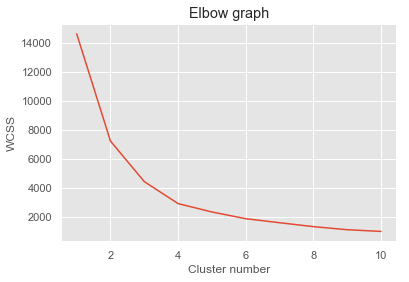

In [98]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df_age_gender)
dn = scaler.transform(df_age_gender)
dn = pd.DataFrame(data=dn, index=df_age_gender.index, columns=df_age_gender.columns)


pca = PCA(n_components=2)
tmp = pca.fit_transform(dn) 

# k means determine k by elbow method
#Find wcss for every K between 1 and 11
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(dn)
    wcss.append(kmeans.inertia_)


#Plot the elbow graph
plt.plot(range(1,11), wcss)
plt.title('Elbow graph')
plt.xlabel('Cluster number')
plt.ylabel('WCSS')
plt.show()

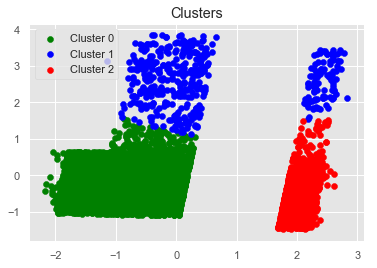

In [99]:
km = KMeans(n_clusters=3)
clusters = km.fit(dn)
cluster_labels = clusters.labels_
clusters = km.fit_predict(dn)


df_age_gender_3 = pd.DataFrame(tmp, columns=['x', 'y']) 

df_age_gender_3['cluster'] = clusters

c1 = df_age_gender_3[df_age_gender_3.cluster == 0]
c2 = df_age_gender_3[df_age_gender_3.cluster == 1]
c3 = df_age_gender_3[df_age_gender_3.cluster == 2]


plt.scatter(c1.x, c1.y, c = 'green', label = 'Cluster 0')
plt.scatter(c2.x, c2.y, c = 'blue', label = 'Cluster 1')
plt.scatter(c3.x, c3.y, c = 'red', label = 'Cluster 2')

plt.title('Clusters')
plt.legend()
plt.show()


df_age_gender_3['client_id'] = column_client_id

In [100]:
df_age_gender['cluster'] = clusters
df_age_gender

,client_id,gender,age,cluster
0,2873,1,44,2
435,976,0,63,0
827,2689,0,96,0
1188,3684,0,57,0
1533,373,0,83,0
1878,2623,0,54,0
2290,5392,0,64,0
2625,3023,0,60,0
2965,3530,1,47,2
3241,660,0,96,0


In [101]:
df_age_gender[df_age_gender['cluster'] == 0].describe()

,client_id,gender,age,cluster
count,3326.000000,3326.0,3326.000000,3326.0
mean,2601.286530,0.0,73.316897,0.0
std,1528.203192,0.0,13.820003,0.0
min,2.000000,0.0,51.000000,0.0
25%,1323.250000,0.0,62.000000,0.0
50%,2569.500000,0.0,73.000000,0.0
75%,3813.500000,0.0,83.000000,0.0
max,7390.000000,0.0,107.000000,0.0


In [102]:
df_age_gender[df_age_gender['cluster'] == 1].describe()

,client_id,gender,age,cluster
count,428.000000,428.000000,428.000000,428.0
mean,10730.707944,0.231308,60.380841,1.0
std,1942.839271,0.422163,12.213070,0.0
min,6366.000000,0.000000,33.000000,1.0
25%,9425.000000,0.000000,51.000000,1.0
50%,10987.500000,0.000000,60.000000,1.0
75%,12335.500000,0.000000,71.000000,1.0
max,13998.000000,1.000000,93.000000,1.0


In [103]:
df_age_gender[df_age_gender['cluster'] == 2].describe()

,client_id,gender,age,cluster
count,1121.000000,1121.0,1121.000000,1121.0
mean,2734.471900,1.0,43.808207,2.0
std,1765.367595,0.0,3.909211,0.0
min,1.000000,1.0,31.000000,2.0
25%,1202.000000,1.0,41.000000,2.0
50%,2619.000000,1.0,44.000000,2.0
75%,4081.000000,1.0,47.000000,2.0
max,8506.000000,1.0,50.000000,2.0


We used the the age and gender to cluster customers by their demographic criteria and we plotted the desciption of every cluster to more understand them and could eventually label them then we applyed the k-means with k = 3.

For the cluster 0, we found an average age up to 73 from 50 to 107 years-old and all the customers of the cluster 0 are females. Therefore, we could name it ancient females.

For the cluster 1, we found an average age up to 60 from 33 to 93 years-old with a female majority customers. So, we could name it mixed juniors.

For the cluster 2, we found an average age up to 43 from 31 to 50 years-old with a fully male cluster customers that's why we could name it senior males.

In [104]:
df_age_gender_3 = df_age_gender_3.replace(0, 'Ancient females')
df_age_gender_3 = df_age_gender_3.replace(1, 'Mixed juniors')
df_age_gender_3 = df_age_gender_3.replace(2, 'Senior males')

In [105]:
df_age_gender_3

,x,y,cluster,client_id
0,2.059790,-0.456735,Senior males,255
1,-0.410287,-0.752268,Ancient females,2717
2,-1.680575,-0.096526,Ancient females,2718
3,-0.045793,0.191100,Ancient females,4704
4,-1.252738,-0.932406,Ancient females,3323
5,0.029653,-0.187093,Ancient females,4491
6,-0.255782,0.803395,Ancient females,4469
7,-0.197392,-0.036706,Ancient females,1334
8,1.966477,-0.220717,Senior males,49
9,-1.770306,-0.810562,Ancient females,379


In [106]:
df_age_gender_3.to_csv (r'C:\Users\ASUS\Downloads\berka\df_age_gender_3.csv', index = None, header=True) 

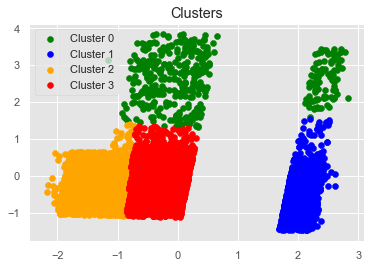

In [107]:
km = KMeans(n_clusters=4)
clusters = km.fit(dn)
cluster_labels = clusters.labels_
clusters = km.fit_predict(dn)


df_age_gender_4 = pd.DataFrame(tmp, columns=['x', 'y']) 

df_age_gender_4['cluster'] = clusters

c1 = df_age_gender_4[df_age_gender_4.cluster == 0]
c2 = df_age_gender_4[df_age_gender_4.cluster == 1]
c3 = df_age_gender_4[df_age_gender_4.cluster == 2]
c4 = df_age_gender_4[df_age_gender_4.cluster == 3]


plt.scatter(c1.x, c1.y, c = 'green', label = 'Cluster 0')
plt.scatter(c2.x, c2.y, c = 'blue', label = 'Cluster 1')
plt.scatter(c3.x, c3.y, c = 'orange', label = 'Cluster 2')
plt.scatter(c4.x, c4.y, c = 'red', label = 'Cluster 3')

plt.title('Clusters')
plt.legend()
plt.show()


df_age_gender_4['client_id'] = column_client_id

In [108]:
df_age_gender['cluster'] = clusters
df_age_gender

,client_id,gender,age,cluster
0,2873,1,44,1
435,976,0,63,3
827,2689,0,96,2
1188,3684,0,57,3
1533,373,0,83,2
1878,2623,0,54,3
2290,5392,0,64,3
2625,3023,0,60,3
2965,3530,1,47,1
3241,660,0,96,2


In [109]:
df_age_gender[df_age_gender['cluster'] == 0].describe()

,client_id,gender,age,cluster
count,420.000000,420.000000,420.000000,420.0
mean,10806.573810,0.233333,60.528571,0.0
std,1879.101525,0.423457,12.364073,0.0
min,6924.000000,0.000000,33.000000,0.0
25%,9456.750000,0.000000,51.000000,0.0
50%,11006.000000,0.000000,60.000000,0.0
75%,12363.250000,0.000000,71.000000,0.0
max,13998.000000,1.000000,93.000000,0.0


In [110]:
df_age_gender[df_age_gender['cluster'] == 1].describe()

,client_id,gender,age,cluster
count,1122.000000,1122.0,1122.000000,1122.0
mean,2739.671123,1.0,43.811052,1.0
std,1773.153245,0.0,3.908629,0.0
min,1.000000,1.0,31.000000,1.0
25%,1202.500000,1.0,41.000000,1.0
50%,2620.500000,1.0,44.000000,1.0
75%,4087.750000,1.0,47.000000,1.0
max,8568.000000,1.0,50.000000,1.0


In [111]:
df_age_gender[df_age_gender['cluster'] == 2].describe()

,client_id,gender,age,cluster
count,1511.000000,1511.0,1511.000000,1511.0
mean,2412.551291,0.0,86.037062,2.0
std,1456.911338,0.0,8.119306,0.0
min,2.000000,0.0,73.000000,2.0
25%,1193.500000,0.0,79.000000,2.0
50%,2303.000000,0.0,85.000000,2.0
75%,3597.500000,0.0,93.000000,2.0
max,7043.000000,0.0,107.000000,2.0


In [112]:
df_age_gender[df_age_gender['cluster'] == 3].describe()

,client_id,gender,age,cluster
count,1822.000000,1822.0,1822.000000,1822.0
mean,2772.737651,0.0,62.691548,3.0
std,1582.025727,0.0,6.920060,0.0
min,4.000000,0.0,51.000000,3.0
25%,1499.500000,0.0,57.000000,3.0
50%,2785.500000,0.0,63.000000,3.0
75%,4011.750000,0.0,69.000000,3.0
max,6906.000000,0.0,76.000000,3.0


We used the the age and gender to cluster customers by their demographic criteria and we plotted the desciption of every cluster to more understand them and could eventually label them then we applyed the k-means with k = 4.

For the cluster 0, we found an average age up to 60 from 33 to 93 years old with a female majority customers that's why we could name it mixed juniors.

For the cluster 1, we found an average age up to 43 from 31 to 50 years old with all of male customers. So, we could name it senior males.

For the cluster 2, we found the average age up to 86 from 73 to 107 years old with a totally female composed cluster so we could name it ancient females.

For the cluster 3, we found an average age up to 62 from 50 to 77 years old and all the customers of the cluster 0 are females. Therefore, we could name it junior females.

In [113]:
df_age_gender_4 = df_age_gender_4.replace(0, 'Mixed juniors')
df_age_gender_4 = df_age_gender_4.replace(1, 'Senior males')
df_age_gender_4 = df_age_gender_4.replace(2, 'Ancient females')
df_age_gender_4 = df_age_gender_4.replace(3, 'Junior females')

In [114]:
df_age_gender_4

,x,y,cluster,client_id
0,2.059790,-0.456735,Senior males,255
1,-0.410287,-0.752268,Junior females,2717
2,-1.680575,-0.096526,Ancient females,2718
3,-0.045793,0.191100,Junior females,4704
4,-1.252738,-0.932406,Ancient females,3323
5,0.029653,-0.187093,Junior females,4491
6,-0.255782,0.803395,Junior females,4469
7,-0.197392,-0.036706,Junior females,1334
8,1.966477,-0.220717,Senior males,49
9,-1.770306,-0.810562,Ancient females,379


In [115]:
df_age_gender_4.to_csv (r'C:\Users\ASUS\Downloads\berka\df_age_gender_4.csv', index = None, header=True) 

In [116]:
#Segmentation per geograpghy 
df_geo = df_joined[['client_id', 'region']]

df_geo = df_geo.drop_duplicates()

In [117]:
df_geo.region.unique()

array(['south Bohemia', 'west Bohemia', 'north Moravia', 'east Bohemia',
       'north Bohemia', 'Prague', 'south Moravia', 'central Bohemia'],
      dtype=object)

In [118]:
df_geo = df_geo.replace('south Bohemia', 0)
df_geo = df_geo.replace('west Bohemia', 1)
df_geo = df_geo.replace('central Bohemia', 2)
df_geo = df_geo.replace('east Bohemia', 3)
df_geo = df_geo.replace('north Bohemia', 4)
df_geo = df_geo.replace('Prague', 5)
df_geo = df_geo.replace('south Moravia', 10)
df_geo = df_geo.replace('north Moravia', 11)

C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  import sys


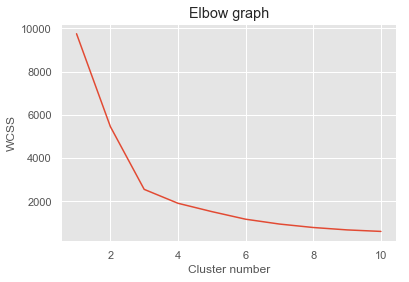

In [119]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df_geo)
data_normal = scaler.transform(df_geo)
data_normal = pd.DataFrame(data=data_normal, index=df_geo.index, columns=df_geo.columns)


pca = PCA(n_components=2)
tmp = pca.fit_transform(data_normal) 

# k means determine k by elbow method
#Find wcss for every K between 1 and 11
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(data_normal)
    wcss.append(kmeans.inertia_)


#Plot the elbow graph
plt.plot(range(1,11), wcss)
plt.title('Elbow graph')
plt.xlabel('Cluster number')
plt.ylabel('WCSS')
plt.show()

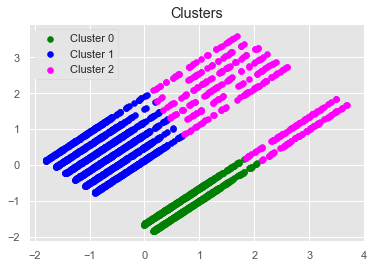

In [120]:
km = KMeans(n_clusters=3)
clusters = km.fit(data_normal)
cluster_labels = clusters.labels_
clusters = km.fit_predict(data_normal)


df_geo_3 = pd.DataFrame(tmp, columns=['x', 'y']) 

df_geo_3['cluster'] = clusters

c1 = df_geo_3[df_geo_3.cluster == 0]
c2 = df_geo_3[df_geo_3.cluster == 1]
c3 = df_geo_3[df_geo_3.cluster == 2]


plt.scatter(c1.x, c1.y, c = 'green', label = 'Cluster 0')
plt.scatter(c2.x, c2.y, c = 'blue', label = 'Cluster 1')
plt.scatter(c3.x, c3.y, c = 'magenta', label = 'Cluster 2')

plt.title('Clusters')
plt.legend()
plt.show()


df_geo_3['client_id'] = column_client_id

In [121]:
df_geo['cluster'] = clusters

In [122]:
df_geo[df_geo['cluster'] == 0].describe()

,client_id,region,cluster
count,1532.000000,1532.000000,1532.0
mean,2693.066580,10.494778,0.0
std,1628.022365,0.500136,0.0
min,9.000000,10.000000,0.0
25%,1312.500000,10.000000,0.0
50%,2584.000000,10.000000,0.0
75%,3966.500000,11.000000,0.0
max,7521.000000,11.000000,0.0


In [123]:
df_geo[df_geo['cluster'] == 1].describe()

,client_id,region,cluster
count,2907.000000,2907.000000,2907.0
mean,2586.025800,2.669075,1.0
std,1538.057799,1.654381,0.0
min,1.000000,0.000000,1.0
25%,1270.500000,1.000000,1.0
50%,2580.000000,3.000000,1.0
75%,3814.500000,4.000000,1.0
max,7339.000000,5.000000,1.0


In [124]:
df_geo[df_geo['cluster'] == 2].describe()

,client_id,region,cluster
count,436.000000,436.000000,436.0
mean,10703.233945,5.525229,2.0
std,1922.150562,3.951058,0.0
min,6501.000000,0.000000,2.0
25%,9365.000000,2.000000,2.0
50%,10870.000000,5.000000,2.0
75%,12324.250000,10.000000,2.0
max,13998.000000,11.000000,2.0


For the gemographic clustering, we applyed k-means with the k = 3 as the kanthal curve showed but we found after treating the results that we have a global cluster which is number 1 and which contains the two clusters 0 and 2 so we could easily discard it and it is what we will do to make labelling more significant and clearer.

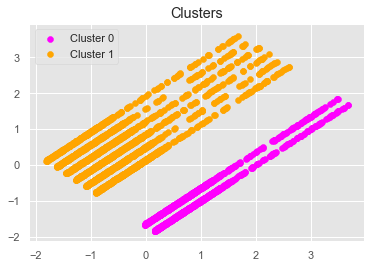

In [125]:
km = KMeans(n_clusters=2)
clusters = km.fit(data_normal)
cluster_labels = clusters.labels_
clusters = km.fit_predict(data_normal)


df_geo_2 = pd.DataFrame(tmp, columns=['x', 'y']) 

df_geo_2['cluster'] = clusters

c1 = df_geo_2[df_geo_2.cluster == 0]
c2 = df_geo_2[df_geo_2.cluster == 1]


plt.scatter(c1.x, c1.y, c = 'magenta', label = 'Cluster 0')
plt.scatter(c2.x, c2.y, c = 'orange', label = 'Cluster 1')

plt.title('Clusters')
plt.legend()
plt.show()


df_geo_2['client_id'] = column_client_id

In [126]:
df_geo['cluster'] = clusters

In [127]:
df_geo[df_geo['cluster'] == 0].describe()

,client_id,region,cluster
count,1688.000000,1688.000000,1688.0
mean,3448.746445,10.492891,0.0
std,2878.297074,0.500098,0.0
min,9.000000,10.000000,0.0
25%,1497.750000,10.000000,0.0
50%,2915.500000,10.000000,0.0
75%,4346.000000,11.000000,0.0
max,13998.000000,11.000000,0.0


In [128]:
df_geo[df_geo['cluster'] == 1].describe()

,client_id,region,cluster
count,3187.000000,3187.000000,3187.0
mean,3291.020082,2.677753,1.0
std,2771.268387,1.657986,0.0
min,1.000000,0.000000,1.0
25%,1405.000000,1.000000,1.0
50%,2787.000000,3.000000,1.0
75%,4176.500000,4.000000,1.0
max,13956.000000,5.000000,1.0


Hence, we coosed k = 2 to visualize the regions of clustering and the descriptionof every cluster showed that for the cluster 0 we have the north and south Moravia while in the cluster 1 we find south, north, east, west, and center Bohemia with of course Prague.

The cluster 0 could absolutely be named Moravian region so.

The cluster 1 could be also named Bohemian region where its capital is Prague of course.

In [129]:
df_geo_2 = df_geo_2.replace(0, 'Moravian')
df_geo_2 = df_geo_2.replace(1, 'Bohemian')

In [130]:
df_geo_2

,x,y,cluster,client_id
0,-1.079486,0.841553,Bohemian,255
1,-1.556981,0.364058,Bohemian,2717
2,-1.125801,0.795238,Bohemian,2718
3,-0.875349,1.045690,Bohemian,4704
4,-1.708762,0.212277,Bohemian,3323
5,-1.142414,0.778625,Bohemian,4491
6,-0.445428,1.475611,Bohemian,4469
7,-1.041730,0.879309,Bohemian,1334
8,-0.914113,1.006926,Bohemian,49
9,-1.636521,0.284518,Bohemian,379


In [131]:
df_geo_2.to_csv (r'C:\Users\ASUS\Downloads\berka\df_geo_2.csv', index = None, header=True) 

In [132]:
#Segmentation per churn probability or CLV

#Calculate the CLV for customers 
table = rfmTable[['Recency', 'Frequency', 'Monetary']]

pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Average Order Value
table.loc[:, 'avg_order_value'] = table.loc[:, 'Monetary'] / table.loc[:, 'Frequency']

#Purchase frequency 
purchase_frequency = table['Frequency'].sum() / table.shape[0]

# Customer Value
table['CLV'] = (table['avg_order_value'] * purchase_frequency)

C:\Users\ASUS\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\ASUS\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [133]:
table.reset_index(level=0, inplace=True)
column_client_id = table['client_id']

In [134]:
table = table[['client_id', 'CLV']]
table

,client_id,CLV
0,255,3859285.20
1,2717,542269.26
2,2718,542269.26
3,4704,1614115.93
4,3323,692200.48
5,4491,762458.25
6,4469,652842.81
7,1334,737074.94
8,49,1710857.55
9,379,861711.05


C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys


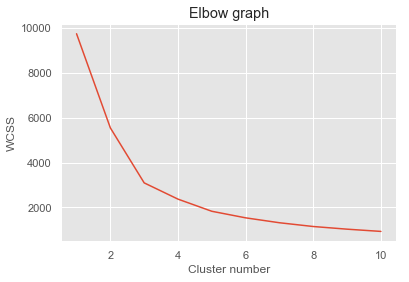

In [135]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(table)
normalized = scaler.transform(table)
normalized = pd.DataFrame(data=normalized, index=table.index, columns=table.columns)


pca = PCA(n_components=2)
tmp = pca.fit_transform(normalized) 

# k means determine k by elbow method
#Find wcss for every K between 1 and 11
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(normalized)
    wcss.append(kmeans.inertia_)


#Plot the elbow graph
plt.plot(range(1,11), wcss)
plt.title('Elbow graph')
plt.xlabel('Cluster number')
plt.ylabel('WCSS')
plt.show()

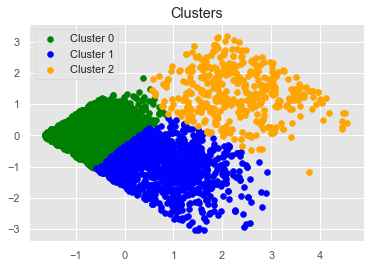

In [136]:
km = KMeans(n_clusters=3)
clusters = km.fit(normalized)
cluster_labels = clusters.labels_
clusters = km.fit_predict(normalized)


tmp_churn_3 = pd.DataFrame(tmp, columns=['x', 'y']) 

tmp_churn_3['cluster'] = clusters

c1 = tmp_churn_3[tmp_churn_3.cluster == 0]
c2 = tmp_churn_3[tmp_churn_3.cluster == 1]
c3 = tmp_churn_3[tmp_churn_3.cluster == 2]


plt.scatter(c1.x, c1.y, c = 'green', label = 'Cluster 0')
plt.scatter(c2.x, c2.y, c = 'blue', label = 'Cluster 1')
plt.scatter(c3.x, c3.y, c = 'orange', label = 'Cluster 2')

plt.title('Clusters')
plt.legend()
plt.show()

tmp_churn_3['client_id'] = column_client_id

In [137]:
table['cluster'] = clusters

In [138]:
table[table['cluster'] == 0].describe()

,client_id,CLV,cluster
count,2963.00,2963.00,2963.00
mean,2471.35,671721.05,0.00
std,1476.97,346499.66,0.00
min,1.00,184560.47,0.00
25%,1187.50,415867.17,0.00
50%,2413.00,545453.26,0.00
75%,3663.50,922591.86,0.00
max,7787.00,1507055.83,0.00


In [139]:
table[table['cluster'] == 1].describe()

,client_id,CLV,cluster
count,1463.00,1463.00,1463.00
mean,2890.29,2249757.57,1.00
std,1664.22,628229.57,0.00
min,9.00,1414514.96,1.00
25%,1523.00,1744723.00,1.00
50%,2880.00,2055879.60,1.00
75%,4138.00,2675264.64,1.00
max,7102.00,4608918.88,1.00


In [140]:
table[table['cluster'] == 2].describe()

,client_id,CLV,cluster
count,449.00,449.00,449.00
mean,10598.80,1800602.59,2.00
std,1988.68,762976.31,0.00
min,6452.00,340377.31,2.00
25%,9226.00,1198068.67,2.00
50%,10746.00,1754015.06,2.00
75%,12221.00,2333462.54,2.00
max,13998.00,4326604.33,2.00


Now, to cluster the customers by their churn or also the value of customer lifetime value (CLV) we need to calculate the CLV attribute first. After calculating and performing the clustering k-means algorithm with k = 3 we find the average values that we are going to deduce from.

Cluster 0 have an average CLV of 672786 with values range between 184560 and 1507055 so this is the cluster having the minimum CLV that could be named short living cluster.

Cluster 1 have an average CLV of 2251916 with values range between 1414514 and 4608918 so this is the most long living cluster that will stay and keep being loyal to the bank.

Cluster 2 have an average CLV of 1800602 with values range between 340377 and 4326604 so this is the well living cluster that has an important CLV. 

In [141]:
tmp_churn_3 = tmp_churn_3.replace(0, 'Short living')
tmp_churn_3 = tmp_churn_3.replace(1, 'Long living')
tmp_churn_3 = tmp_churn_3.replace(2, 'Well living')

In [142]:
tmp_churn_3

,x,y,cluster,client_id
0,1.32,-2.87,Long living,255
1,-0.73,0.41,Short living,2717
2,-0.73,0.41,Short living,2718
3,0.63,0.05,Long living,4704
4,-0.45,0.44,Short living,3323
5,-0.10,0.68,Short living,4491
6,-0.20,0.76,Short living,4469
7,-0.92,-0.10,Short living,1334
8,-0.46,-1.20,Long living,49
9,-1.06,-0.44,Short living,379


In [143]:
tmp_churn_3.to_csv (r'C:\Users\ASUS\Downloads\berka\df_churn_3.csv', index = None, header=True) 

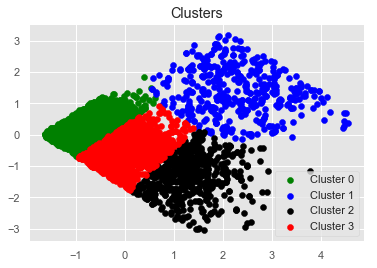

In [144]:
km = KMeans(n_clusters=4)
clusters = km.fit(normalized)
cluster_labels = clusters.labels_
clusters = km.fit_predict(normalized)


tmp_churn_4 = pd.DataFrame(tmp, columns=['x', 'y']) 

tmp_churn_4['cluster'] = clusters

c1 = tmp_churn_4[tmp_churn_4.cluster == 0]
c2 = tmp_churn_4[tmp_churn_4.cluster == 1]
c3 = tmp_churn_4[tmp_churn_4.cluster == 2]
c4 = tmp_churn_4[tmp_churn_4.cluster == 3]


plt.scatter(c1.x, c1.y, c = 'green', label = 'Cluster 0')
plt.scatter(c2.x, c2.y, c = 'blue', label = 'Cluster 1')
plt.scatter(c3.x, c3.y, c = 'black', label = 'Cluster 2')
plt.scatter(c4.x, c4.y, c = 'red', label = 'Cluster 3')

plt.title('Clusters')
plt.legend()
plt.show()

tmp_churn_4['client_id'] = column_client_id

In [145]:
table['cluster'] = clusters

In [146]:
table[table['cluster'] == 0].describe()

,client_id,CLV,cluster
count,2450.00,2450.00,2450.00
mean,2476.18,544693.89,0.00
std,1472.63,221566.88,0.00
min,1.00,184560.47,0.00
25%,1188.25,386666.56,0.00
50%,2417.50,501259.08,0.00
75%,3691.25,672021.99,0.00
max,7787.00,1091720.45,0.00


In [147]:
table[table['cluster'] == 1].describe()

,client_id,CLV,cluster
count,444.00,444.00,444.00
mean,10629.86,1784222.21,1.00
std,1977.22,746319.12,0.00
min,6729.00,340377.31,1.00
25%,9275.50,1188517.25,1.00
50%,10788.00,1742939.69,1.00
75%,12304.25,2317647.68,1.00
max,13998.00,3883558.94,1.00


In [148]:
table[table['cluster'] == 2].describe()

,client_id,CLV,cluster
count,609.00,609.00,609.00
mean,3332.65,2880616.91,2.00
std,1791.77,473724.37,0.00
min,24.00,2103839.06,2.00
25%,1978.00,2518529.17,2.00
50%,3387.00,2788363.11,2.00
75%,4711.00,3145235.37,2.00
max,8506.00,4608918.88,2.00


In [149]:
table[table['cluster'] == 3].describe()

,client_id,CLV,cluster
count,1372.00,1372.00,1372.00
mean,2546.70,1610193.14,3.00
std,1525.51,315543.50,0.00
min,2.00,1073293.73,3.00
25%,1258.25,1346978.75,3.00
50%,2538.50,1603259.80,3.00
75%,3775.75,1863744.35,3.00
max,6552.00,2412138.89,3.00


Now, to cluster the customers by their churn or also the value of customer lifetime value (CLV) we need to calculate the CLV attribute first. After calculating and performing the clustering k-means algorithm with k = 3 we find the average values that we are going to deduce from.

Cluster 0 have an average CLV of 544482 with values range between 184560 and 1091720 so this is the short living cluster that will leaving the bank as soon as possible.

Cluster 1 have an average CLV of 1784222 with values range between 340377 and 3883558 so this is the very well living cluster having an important CLV average. 

Cluster 2 have an average CLV of 2880616 with values range between 2103839 and 4608918 so this most long living cluster that will keep being a part of the bank. 

Cluster 3 have an average CLV of 1609794 with values range between 1062585 and 2412138 so this is the well living cluster that has good CLV.

In [150]:
tmp_churn_4 = tmp_churn_4.replace(0, 'Short living')
tmp_churn_4 = tmp_churn_4.replace(1, 'Very well living')
tmp_churn_4 = tmp_churn_4.replace(2, 'Long living')
tmp_churn_4 = tmp_churn_4.replace(3, 'Well living')

In [151]:
tmp_churn_4

,x,y,cluster,client_id
0,1.32,-2.87,Long living,255
1,-0.73,0.41,Short living,2717
2,-0.73,0.41,Short living,2718
3,0.63,0.05,Well living,4704
4,-0.45,0.44,Short living,3323
5,-0.10,0.68,Short living,4491
6,-0.20,0.76,Short living,4469
7,-0.92,-0.10,Short living,1334
8,-0.46,-1.20,Well living,49
9,-1.06,-0.44,Short living,379


In [152]:
tmp_churn_4.to_csv (r'C:\Users\ASUS\Downloads\berka\df_churn_4.csv', index = None, header=True) 

# Clustering table for k=3

In [153]:
clustering_3 = df_loyalty_3[['client_id', 'cluster']]
clustering_3 = clustering_3.rename(columns={"cluster": "loyalty_cluster"})

clustering_3['age_cluster'] = tmp_age_3['cluster']

clustering_3['gender_cluster'] = df_gender_2['gender']

clustering_3['age_gender_cluster'] = df_age_gender_3['cluster']

clustering_3['geo_cluster'] = df_geo_2['cluster']

clustering_3['churn_cluster'] = tmp_churn_3['cluster']

In [154]:
clustering_3

,client_id,loyalty_cluster,age_cluster,gender_cluster,age_gender_cluster,geo_cluster,churn_cluster
0,255,Risky,Senior,male,Senior males,Bohemian,Long living
1,2717,Risky,Senior,male,Ancient females,Bohemian,Short living
2,2718,Risky,Old,male,Ancient females,Bohemian,Short living
3,4704,Best,Senior,male,Ancient females,Bohemian,Long living
4,3323,Risky,Old,male,Ancient females,Bohemian,Short living
5,4491,Risky,Senior,male,Ancient females,Bohemian,Short living
6,4469,Risky,Senior,male,Ancient females,Bohemian,Short living
7,1334,Risky,Senior,male,Ancient females,Bohemian,Short living
8,49,Best,Senior,male,Senior males,Bohemian,Long living
9,379,Risky,Old,male,Ancient females,Bohemian,Short living


In [155]:
clustering_3.to_csv (r'C:\Users\ASUS\Downloads\berka\clustering_3.csv', index = None, header=True) 

# Clustering table for k=4

In [156]:
clustering_4 = df_loyalty_4[['client_id', 'cluster']]
clustering_4 = clustering_4.rename(columns={"cluster": "loyalty_cluster"})

clustering_4['age_cluster'] = tmp_age_4['cluster']

clustering_4['gender_cluster'] = df_gender_2['gender']

clustering_4['age_gender_cluster'] = df_age_gender_4['cluster']

clustering_4['geo_cluster'] = df_geo_2['cluster']

clustering_4['churn_cluster'] = tmp_churn_4['cluster']

In [157]:
clustering_4

,client_id,loyalty_cluster,age_cluster,gender_cluster,age_gender_cluster,geo_cluster,churn_cluster
0,255,Risky,Senior,male,Senior males,Bohemian,Long living
1,2717,About to sleep,Ancient junior,male,Junior females,Bohemian,Short living
2,2718,About to sleep,Old,male,Ancient females,Bohemian,Short living
3,4704,Best,Senior,male,Junior females,Bohemian,Well living
4,3323,About to sleep,Old,male,Ancient females,Bohemian,Short living
5,4491,About to sleep,Senior,male,Junior females,Bohemian,Short living
6,4469,About to sleep,Ancient junior,male,Junior females,Bohemian,Short living
7,1334,About to sleep,Ancient junior,male,Junior females,Bohemian,Short living
8,49,Best,Senior,male,Senior males,Bohemian,Well living
9,379,About to sleep,Old,male,Ancient females,Bohemian,Short living


In [116]:
clustering_4.to_csv (r'C:\Users\ASUS\Downloads\berka\clustering_4.csv', index = None, header=True) 